# Lab 1:  Basics of Testing
Welcome to the first Data 102 lab! 

The goals of this lab are to get familiar with concepts in decision theory. We will learn more about testing, p-values and FDR control.

The code you need to write is commented out with a message **"TODO: fill in"**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Wednesday, Sep 9th, 2020 at 11:59 PM. PST**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

# Setup
Let's begin by importing the libraries we will use. You can find the documentation for the libraries here:
* matplotlib: https://matplotlib.org/3.1.1/contents.html
* numpy: https://docs.scipy.org/doc/
* pandas: https://pandas.pydata.org/pandas-docs/stable/
* seaborn: https://seaborn.pydata.org/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num):  # <- helper function for assessing correctness
    return hashlib.md5(str(num).encode()).hexdigest()

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question 1: Hypothesis testing, LRT, decision rules, P-values.

The first question looks at the basics of testing. You will have to put yourself in the shoes of a detective who is trying to use 'evidence' to find the 'truth'. Given a piece of evidence $X$ your job will be to decide between two hypotheses. The two hypothesis you consider are:

_The null hypothesis:_
$$ H_0: X\sim \mathcal{N}(0,1)$$
_The alternative hypothesis:_
$$ H_1: X \sim \mathcal{N}(2,1)$$

Granted you don't know the truth, but you have to make a decision that maximizes the True Positive Probability and minimizes the False Positive Probability.

**In this exercise you will look at:**
 - The intuitive relationship between Likelihood Ratio Test and decisions based on thresholding $X$.
 - The performance of a level-$\alpha$ test.
 - The distribution of p-values for samples from the null distribution as well as samples from the alternative.
 
#### Let's start by plotting the distributions of the null and alternative hypothesis.


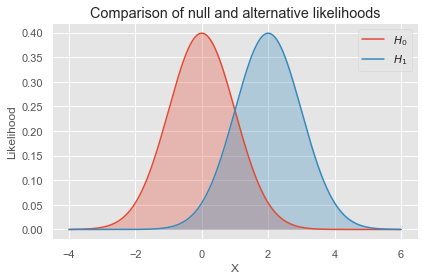

In [2]:
# NOTE: you just need to run this cell to plot the pdf; don't change this code.
def null_pdf(x):
    return norm.pdf(x,0,1)
def alt_pdf(x):
    return norm.pdf(x,2,1)

# Plot the distribution under the null and alternative
x_axis = np.arange(-4, 6, 0.001)

plt.plot(x_axis, null_pdf(x_axis), label = '$H_0$') # <- likelihood under the null
plt.fill_between(x_axis, null_pdf(x_axis), alpha = 0.3)

plt.plot(x_axis, alt_pdf(x_axis),  label = '$H_1$') # <- likelihood alternative
plt.fill_between(x_axis, alt_pdf(x_axis), alpha = 0.3)

plt.xlabel("X")
plt.ylabel("Likelihood")
plt.title("Comparison of null and alternative likelihoods");
plt.legend()
plt.tight_layout()
plt.show()

By inspecting the image above we can see that if the data lies towards the right, then it seems more plausible that the alternative is true. For example $X\geq1.64$ seems much less likely to belong to the null pdf than the alternative pdf.

### Likelihood Ratio Test
In class we said that the optimal test is the Likelihood Ratio Test (LRT), which is the result of the celebrated Neyman-Pearson Lemma. It says that the optimal level $\alpha$ test is the one that rejects the null (aka makes a discovery, accepts the alternative) whenever:
$$LR(x):=\frac{f_1(x)}{f_0(x)} \geq \eta$$
where $\eta$ is chosen such that the false positive rate is equal to $\alpha$.

### But how does this result fit with the intuition that we should set a decision threshold based on the value of $X$ directly?

This exercise will formalize that intuition:

Let's start by computing the ratio of the likelihoods. The likelihood of $X\sim \mathcal N(\mu,\sigma)$ is:
$$f_{\sigma, \mu}(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Luckily `scipy` has a nifty function to compute the likelihood of gaussians `scipy.norm.pdf(x, mu, sigma)`


 
## Part 1.a:  Calculate likelihood ratios

Complete the function below that computes the likelihood ratio for any value `x`.

In [3]:
# TODO: fill in the missing expression for the likelihood ratio in the function below
def calculate_likelihood_ratio(x):
    """
    Computes the likelihood ratio between the alternative and null hypothesis.
    
    Inputs:
        x: value for which to compute the likelihool ratio
    
    Outputs:
        lr : the likelihood ratio at point x
    """
    
    L0 = null_pdf(x)
    L1 = alt_pdf(x)
    LR = L1/L0# TODO: fill the likelihood ratio
    return LR

In [4]:
# Compute the likelihood ratio for X=1.64
X=1.64
LR = calculate_likelihood_ratio(X)
print(LR)
assert(get_hash(LR)== 'f9983e1a6585502f3006cb6d1c1edec3')
print("Test passed!")

3.59663972556928
Test passed!


#### Let's plot the likelihood ratios for different values of $X$:

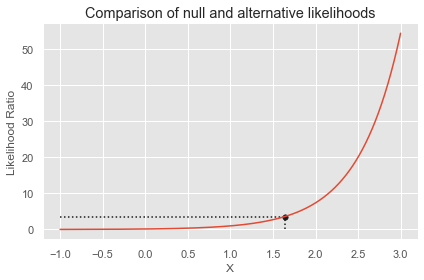

In [5]:
# The code below plots the LR for different values of X
# Once you've filled in `calculate_likelihood_ratio` run this cell and inspect the plot
x_axis = np.arange(-1, 3, 0.001)
plt.plot(x_axis, calculate_likelihood_ratio(x_axis))
plt.vlines(X, 0, LR, linestyle="dotted", color='k')
plt.hlines(LR, -1, X, linestyle="dotted", color='k')
plt.scatter(X, LR, 30, color='k')
plt.xlabel("X")
plt.ylabel("Likelihood Ratio")
plt.title("Comparison of null and alternative likelihoods");
plt.tight_layout()
plt.show()

The plot above illustrates that deciding based on LRT with $\eta = 3.6$ is equivalent to deciding in the favor of the alternative whenever $X\geq 1.64$. The set $[1.64, +\infty)$ is called the **rejection region** of the test, because for all X values in the rejection region the test rejects the null in the favor of the alternative. This illustrates that our intuition was correct.

When thinking in terms of likelihood ratios it seems very tricky to compute the False Positive Rate (FPR), however in this case we can bypass that by testing based on the value of $X$.

#### The figure below illustrates pictorially the FPR when testing based on the threshold $X\geq1.64$


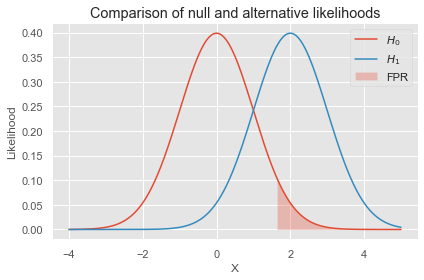

In [6]:
x_axis = np.arange(-4, 5, 0.001)


plt.plot(x_axis, null_pdf(x_axis), label = '$H_0$') # <- likelihood under the null
plt.plot(x_axis, alt_pdf(x_axis),  label = '$H_1$') # <- likelihood alternative

rejection_region = np.arange(X, 5, 0.001) # <- truncate the true rejection region for plotting purposes
plt.fill_between(rejection_region, null_pdf(rejection_region), alpha = 0.3, label="FPR")

plt.xlabel("X")
plt.ylabel("Likelihood")
plt.title("Comparison of null and alternative likelihoods");
plt.legend()
plt.tight_layout()
plt.show()

Under the null hypothesis it is still possible to observe values in the tail of distribution. The probability of that happening is exactly FPR (and it is illustrated by the shaded area under the null curve). Assume that we are using the test that rejects for all $X \geq \tau$. FPR can then be computed as:

$$FPR(\tau) = \mathbb{P}\{X>\tau|H_0 \text{ is true}\} = 1 - \mathbb{P}\{X<\tau|H_0 \text{ is true}\} = 1 - F(
\tau)$$

where $F(\cdot)$ denotes the CDF of the null distributions, which in this case is the standard gaussian. 

## Part 1.b: Calculate the probability of False Positives
In the cell below calculate the FPR for this test. 

**Hint**, the cdf of a standard normal might come in handy for this function: `scipy.stats.norm.cdf`

In [7]:
# TODO: fill in the missing expression for FPR
def calculate_fpr(tau):
    """
    Calculates the FPR for the test based on thresholding X>=tau.
    It assumes that the null distribution is the standard gaussian N(0,1)
    
    Inputs:
        tau: test threshold
    
    Outputs:
        fpr: false positive rate
    """
    fpr = 1 - norm.cdf(tau) # TODO: fill in
    return fpr



In [8]:
# Once you've filled `calculate_fpr` you can run this to test for correctness
thresholds = [0, 0.5, 1, 2, 3]
fpr_vals = calculate_fpr(thresholds)
hash_list = ['d310cb367d993fb6fb584b198a2fd72c', 
             '77d8304f0ac6b94895e8061eff588d52', 
             'df26eb4f07782680a6d98b89313aadc1', 
             'e575e59c20eeeda5d6a29f5ed3e1e2c7', 
             'f233728ef2007eef8f97f8432837feee']
assert[get_hash(fpr) == hash_list[i] for (i, fpr) in enumerate(fpr_vals)]
print("Test passed!!!")

Test passed!!!


#### Let's now compute the FPR for a test that rejects whenever $X\geq 1.64$

In [9]:
# Calculate the false positive rate
X = 1.64
fpr = calculate_fpr(X)
print(fpr)

0.050502583474103746


#### Looks like we got really lucky!!! The threshold we choose has a FPR of $\sim 5\%$. 

## Part 1.c: Make a level-$\alpha$ decision rule

Complete the function below to create a decision rule that has $FPR=\alpha$. Given that we are working with Gaussian this test is exactly the Z-score test that you might have learned in previous classes.

**Hint**, the inverse cdf of a standard normal might come in handy for this function: `scipy.stats.norm.ppf`


In [10]:
# TODO: complete this function
def make_decision(X, alpha):
    """
    Makes a decision whether to accept or reject the null hypothesis for point X at level alpha
    
    Inputs:
        X: point at which to test
        alpha: desired FPR rate for the decision rule (also known as significance level)
    
    Outputs:
        decision: {0, 1} 0-accept the null, 1-reject the null
    """
    
    threshold = norm.ppf(1-alpha) # TODO: compute the threshold for which the FPR of the test is equal to alpha (see Hint)
    decision = X>=threshold # TODO: compute the decision; 1 stands for rejecting the null
    return decision

In [11]:
# Once you've filled `make_decision` run this to perform this test 
# for a few values of X at different levels alpha
X_vals = np.array([0, 0.5, 1, 2, 3])
alphas = np.array([0.01, 0.05, 0.1, 0.2])
for alpha in alphas:
    decisions = make_decision(X_vals, alpha)
    print('At FPR={} the null hypothesis is rejected for X = {}'.format(alpha, X_vals[decisions==1]))

At FPR=0.01 the null hypothesis is rejected for X = [3.]
At FPR=0.05 the null hypothesis is rejected for X = [2. 3.]
At FPR=0.1 the null hypothesis is rejected for X = [2. 3.]
At FPR=0.2 the null hypothesis is rejected for X = [1. 2. 3.]


In [12]:
# Running correctness tests: Do not modify
hashes = ['cfcd208495d565ef66e7dff9f98764da','c4ca4238a0b923820dcc509a6f75849b']
hashes_ids = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
import itertools
inputs = itertools.product(X_vals, alphas)
outputs = [int(make_decision(*input)) for input in inputs]
for (i, output) in enumerate(outputs):
    assert(get_hash(output)==hashes[hashes_ids[i]])
print("Test passed!!!")

Test passed!!!


## Part 1.d: Compute P-values
Let's take a step back and look at what have we accomplished. We came up with a decision rule that accepts/rejects the null hypothesis for a piece of evidence $X$. The test is parametrized at a level $\alpha$ chosen a-priori to reflect our aversion to False Positives.

However, testing returns a binary output: _Reject_ or _Accept_ (1 or 0). In the example above, at level $\alpha = 0.01$ we reject the null only for $X=3$, however at level $\alpha = 0.05$ we reject the null for $X=2$ as well. We have already seen that increasing the FPR increases the rejection region of the test. However you might wonder for $X=2$, what is the smallest $\alpha$ level, such that the corresponding test rejects the null hypothesis in the favor of the alternative?

P-values try to answer exactly that question: 

**"Given a point $X$, and a family of tests parametrized by $\alpha$, what is the smallest $\alpha$ for which the test rejects the null?"**

$$p(X) = \min_{\alpha}: Decision_{\alpha}(X) = 1$$

Hence, P-values tell us something more than just a binary accept/reject answer. The P-value associated with the point $X$ quantifies the *strength of the evidence in the favor of rejecting the null*. Small P-values suggest that the evidence is significant, while large P-values suggest that there is little evidence.

### In the cell below write a function that computes the P-values, for a point $X$. 

**Hint**: You already wrote that function in one of the previous exercises, it just had a different name.

In [13]:
# TODO: complete this function
def calculate_p_value(X):
    """
    Calculates the P-values for the point X
    
    Inputs:
        X: data point
    
    Outputs:
        p_value: P(X)
    """
    p_value = 1 - norm.cdf(X) # TODO: fill in
    return(p_value)

In [14]:
# Once you've filled `calculate_p_value`, run this to compute P-Values for a few X samples.
X_vals = np.array([0, 0.5, 1, 2, 3])
[print('X = {}, P(X) = {}'.format(X, calculate_p_value(X))) for X in X_vals]
print()

X = 0.0, P(X) = 0.5
X = 0.5, P(X) = 0.3085375387259869
X = 1.0, P(X) = 0.15865525393145707
X = 2.0, P(X) = 0.02275013194817921
X = 3.0, P(X) = 0.0013498980316301035



In [15]:
# Running correctness tests: Do not modify
p_vals = calculate_p_value(X_vals)
hash_list = ['d310cb367d993fb6fb584b198a2fd72c', 
             '77d8304f0ac6b94895e8061eff588d52', 
             'df26eb4f07782680a6d98b89313aadc1', 
             'e575e59c20eeeda5d6a29f5ed3e1e2c7', 
             'f233728ef2007eef8f97f8432837feee']
assert[get_hash(pv) == hash_list[i] for (i, pv) in enumerate(p_vals)]
print("Test passed!!!")

Test passed!!!


## Part 1.e: Distribution of p-values
Now, we are going to imagine that we have a bunch of samples (each drawn either from the null distribution or the alternative distribution). We want to predict whether each sample was generated from $H_0$ or $H_1$ by looking at it's p-value. As a reminder, the two hypothesis to consider are:

_The null hypothesis:_
$$ H_0: X\sim \mathcal{N}(0,1)$$
_The alternative hypothesis:_
$$ H_1: X \sim \mathcal{N}(2,1)$$

Assume there are $n=10000$ draws, approximatively 80% of which are nulls (Reality = 0).

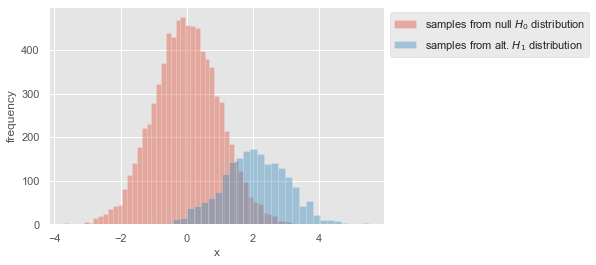

In [16]:
# NOTE: you just need to run this cell to instantiate variables; don't change this code.

rs = np.random.RandomState(0)
n = 10000

# roughly 80% of the data comes from the null distribution
# true_values is an n-dimensional array of indicators, where "1" means that x is from the alternative 
true_values = rs.binomial(1, 0.2, n)

# null distribution is N(0, 1) and alternative distribution is N(2, 1)
x_obs = rs.randn(n) + 2*true_values

sns.distplot(x_obs[np.where(true_values == 0)],  label="samples from null $H_0$ distribution", kde=False)
sns.distplot(x_obs[np.where(true_values == 1)],  label="samples from alt. $H_1$ distribution", kde=False)

plt.xlabel("x")
plt.ylabel("frequency")
plt.legend(bbox_to_anchor=(1,1));

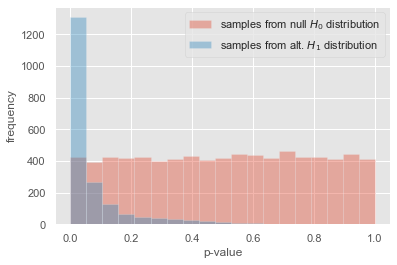

In [17]:
# NOTE: you just need to run this cell and understand what it does; no code to modify or write here. 
# calculate the p-values for each individual hypothesis
p_values = calculate_p_value(x_obs)

bins = np.linspace(0,1,num=20)
sns.distplot(p_values[np.where(true_values == 0)],  label="samples from null $H_0$ distribution", kde=False, bins=bins)
sns.distplot(p_values[np.where(true_values == 1)],  label="samples from alt. $H_1$ distribution", kde=False,bins=bins)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("p-value")
plt.ylabel("frequency");

### What do you notice?

The p-values corresponding to sample data points that came from the null are uniformly distributed in the interval [0,1]. The p-values of samples from the alternative have a much more skewed distribution. A large number of the alternative p-values fall into the [0.0-0.05] bucket, which suggests that this test has a reasonable TPR.

# Question 2: Multiple Testing - Procedures to control false discovery rate.

In the previous example we looked primarily at controling row-wise quantities. And specifically we came up with a decision rules that controls the false positive rate to a desired level $\alpha$. 

Now we are switching perspectives and are thiking about a column-wise quantity. Our goal is to control the probability of false discoveries in this decision-making process for multiple hypothesis testing.

We will use three methods for making discoveries:

    1. Naive thresholding (ignoring that multiple testing is happening)
    2. Using Bonferroni correction to account for multiple testing
    3. The Benjamini-Hochberg procedure for multiple testing

    
or each method, we will assess the decisions made on a simulated data set. 

## Part 2.a: Fill in the following functions regarding confusion matrices.

These functions will be important for reporting your results in a standardized way; later code assumes that you have implemented them so start here.

In [18]:
# TODO: complete this function
def report_results(predicted_discoveries, truth):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `predicted_discoveries`
    and `truth` arrays.
    
    Inputs:
      predicted discoveries: array of 0/1 values where 1 indicates a "discovery".
      truth: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    # populate the following dictionary with counts (NOT rates)
    # TODO: fill in each of these counts
    TP_count = sum(predicted_discoveries*truth)# TODO: fill in
    TN_count = sum((1-predicted_discoveries)*(1-truth))# TODO: fill in
    FP_count = sum((predicted_discoveries)*(1-truth))# TODO: fill in
    FN_count = sum((1-predicted_discoveries)*(truth))# TODO: fill in
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    
    # this function is defined for you below
    print_confusion_matrix(results_dictionary)
    return results_dictionary

# TODO: complete this function
def print_false_discovery_fraction(results_dictionary):
    total_predicted_discoveries = results_dictionary["FP_count"] + results_dictionary["TP_count"]# TODO: fill in
    false_predicted_discoveries = results_dictionary["FP_count"]# TODO: fill in
    
    # TODO: fill in - compute the false discovery fraction from the `results` dictionary
    false_discovery_frac = false_predicted_discoveries/total_predicted_discoveries # TODO: fill in
    
    print("total discoveries: {0}".format(total_predicted_discoveries))
    print("fraction of discoveries which were actually false: {0:.3f}".format(false_discovery_frac))
    return total_predicted_discoveries, false_discovery_frac

def print_confusion_matrix(res_dict):
    # This is a helper function to print the confusion matrix. You don't need to modify this code.
    results_df = pd.DataFrame(data = {"Decision = 0": [res_dict['TN_count'], res_dict['FN_count']], 
                                      "Decision = 1":  [res_dict['FP_count'], res_dict['TP_count']]},
                             index=["Truth = 0", "Truth = 1"])
    print(results_df)


## Part 2.b: Naive thresholding
Here we will investigate the result of using the threshold $\alpha = 0.05$ to test each hypothesis independently, ignoring that we are in a multiple testing scenario. 

Fill in the code for the function below to test each hypothesis at significance level $\alpha$.

**Hint** this is very simular to the `make_decision` function you wrote in Problem 1. There the input to the test was the sample value $X$, however here the input is P-value: $p(X)$.

In [19]:
# TODO: calculate decisions based on thresholding
def naive_alpha_threshold(p_values, alpha):
    """
    Returns decisions on p-values using naive (uncorrected) thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    # TODO: fill in all 
    decisions = p_values <= alpha# TODO: fill in
    return decisions

In [20]:
# Once you've filled in `naive_alpha_threshold`, run this cell to print the results.
# set alpha 
alpha = 0.05

# Using the p-values from Part 1.e, we compute the decision according to the naive function
naive_decisions = naive_alpha_threshold(p_values, alpha)

results = report_results(naive_decisions,true_values)
print()
print_false_discovery_fraction(results)
print()

           Decision = 0  Decision = 1
Truth = 0          7628           400
Truth = 1           679          1293

total discoveries: 1693
fraction of discoveries which were actually false: 0.236



## Part 2.c: Bonferroni Correction
Here we will investigate the result of using Bonferroni-corrected p-values to declare discoveries.
First, implement the Bonfreroni procedure in the function below. 

Recall that for testing $n$ hypotheses with family-wise error rate (FWER) $\leq \alpha$, the resulting procedure is to test each hypothesis with significance $\frac{\alpha}{n}$.

In [21]:
# TODO: calculate the decisions based on the bonferroni correction procedure.
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    # TODO: fill in all 
    n = len(p_values)
    decisions =  p_values <= alpha/n# TODO: fill in
    
    return decisions

In [22]:
# Once you've filled in `bonferroni`, run this cell to print the results. 
bonferroni_decisions = bonferroni(p_values, alpha)

results = report_results(bonferroni_decisions,true_values)
print()
print_false_discovery_fraction(results)
print()

           Decision = 0  Decision = 1
Truth = 0          8028             0
Truth = 1          1957            15

total discoveries: 15
fraction of discoveries which were actually false: 0.000



## Part 2.d: Benjamini-Hochberg
Now we will investigate the result of implementing Benjamini-Hochberg procedure for multiple hypothesis testing.
First, implement the Benjamini-Hochberg procedure in the function below. 

Recall that for testing $n$ hypotheses with false discovery rate (FDR) $\leq \alpha$, the resulting procedure is to find the largest $k$ such that the $k^{th}$-largest of the $n$ p-values is less than or equal to $k \frac{\alpha}{n}$:
$$ P_{(k)} \leq k \frac{\alpha}{n}$$
We then declare a discovery for all p-values with value less than or equal to this $k^{th}$ p-value. 

In [23]:
# TODO: calculate decisions based on Benjamini-Hochberg procedure
def benjamini_hochberg(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """

    n = len(p_values)
    k = 0
    sorted_p = np.sort(p_values)
    
    for i in reversed(range(n)):
        if sorted_p[i] <= (i + 1) * (alpha / n):
            break;

    decisions = p_values <= sorted_p[i]
    return decisions
    
    return decisions

Now, asses the result of applying the Benjamini Hochberg procedure to the simulated data.

In [24]:
# Once you've filled in `benjamini_hochberg`, run this cell to print the results.
bh_decisions = benjamini_hochberg(p_values, alpha)

bh_results = report_results(bh_decisions,true_values)
print()

print_false_discovery_fraction(bh_results)


           Decision = 0  Decision = 1
Truth = 0          8011            17
Truth = 1          1581           391

total discoveries: 408
fraction of discoveries which were actually false: 0.042


(408, 0.041666666666666664)

## Part 2.e: Conclusions
Finally, write a short (<= 4 sentences) summary comparing the three different methods from this problem.

In this problem we are tasked with controlling the FDR. We see that applying the Naive procedure does not control the FDR. This is not surprising as the Naive test is designed to control the FPR. The Bonferroni correction is aimed at controlling FWER. FWER control implied FDR control since it can be shown that FWER >= FDR. However this approach is too strict leading to far too few discoveries. The BH procedure provides a less conservative approach, as it specifically designed for FDR control We can see from this example that the empirical performance of the procedure is equal to 0.042 which is close to the goal of 0.05.

## Final tests
If all the tests below pass you can assume you have successfuly completed the testable parts of the lab. Don't worry about understanding the code below; just make sure no asserts fail.

In [25]:

def assert_discoveries(results,
                       true_vales,
                       true_positives_hash,
                       false_positives_hash,
                       true_negatives_hash,
                       false_negatives_hash,
                       false_discovery_frac_hash):
    def get_hash(num):
        return hashlib.md5(str(num).encode()).hexdigest()
    res_dict = report_results(results, true_values)

    assert(get_hash(res_dict['TP_count']) == true_positives_hash)
    assert(get_hash(res_dict['FP_count']) == false_positives_hash)
    assert(get_hash(res_dict['TN_count']) == true_negatives_hash)
    assert(get_hash(res_dict['FN_count']) == false_negatives_hash)
    _, false_discovery_frac = print_false_discovery_fraction(res_dict)
    print(get_hash(false_discovery_frac))
    assert(get_hash(false_discovery_frac) == false_discovery_frac_hash)
    print()
    

assert_discoveries(naive_decisions,
                   true_values,
                   true_positives_hash="7c82fab8c8f89124e2ce92984e04fb40",
                   false_positives_hash="18d8042386b79e2c279fd162df0205c8",
                   true_negatives_hash="7bb16972da003e87724f048d76b7e0e1",
                    false_negatives_hash="ca9c267dad0305d1a6308d2a0cf1c39c",
                   false_discovery_frac_hash="87600af3ad8560db2ef1ec43fc0e9877")

assert_discoveries(bonferroni_decisions,
                   true_values,
                   true_positives_hash="9bf31c7ff062936a96d3c8bd1f8f2ff3",
                   false_positives_hash="cfcd208495d565ef66e7dff9f98764da",
                   true_negatives_hash="f8e918489f1e0a81ff11312f4d0630c1",
                   false_negatives_hash="277a78fc05c8864a170e9a56ceeabc4c",
                   false_discovery_frac_hash="30565a8911a6bb487e3745c0ea3c8224")

assert_discoveries(bh_decisions,
                   true_values,
                   true_positives_hash="5a4b25aaed25c2ee1b74de72dc03c14e",
                   false_positives_hash="70efdf2ec9b086079795c442636b55fb",
                   true_negatives_hash="e1226495c14f1a62ae17aa76c1f0d457",
                   false_negatives_hash="88a199611ac2b85bd3f76e8ee7e55650",
                   false_discovery_frac_hash="eac9ed4c22d75c17b5211c4c2468bd52")
    
print("All tests passed! You are awesome!!!")

           Decision = 0  Decision = 1
Truth = 0          7628           400
Truth = 1           679          1293
total discoveries: 1693
fraction of discoveries which were actually false: 0.236
87600af3ad8560db2ef1ec43fc0e9877

           Decision = 0  Decision = 1
Truth = 0          8028             0
Truth = 1          1957            15
total discoveries: 15
fraction of discoveries which were actually false: 0.000
30565a8911a6bb487e3745c0ea3c8224

           Decision = 0  Decision = 1
Truth = 0          8011            17
Truth = 1          1581           391
total discoveries: 408
fraction of discoveries which were actually false: 0.042
eac9ed4c22d75c17b5211c4c2468bd52

All tests passed! You are awesome!!!
